In [23]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import tqdm
import datetime
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

import loader
import enedis_custom_metric_example as metrics
import data_vis as vis
import data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using TensorFlow backend.


In [2]:
# LOAD DATA
min_timestamp = 1381694400
x_res, y_res, x_com, y_com, x_labels = loader.load_data(train_file_feat='training_input_qFI2jug.csv',
                                                        train_file_label='training_output_uamzSZW.csv',
                                                        test_file_feat = 'testing_input_BcjTmnd.csv',
                                                        min_timestamp=min_timestamp)
n_res, n_com = x_res.shape[0], y_res.shape[0]

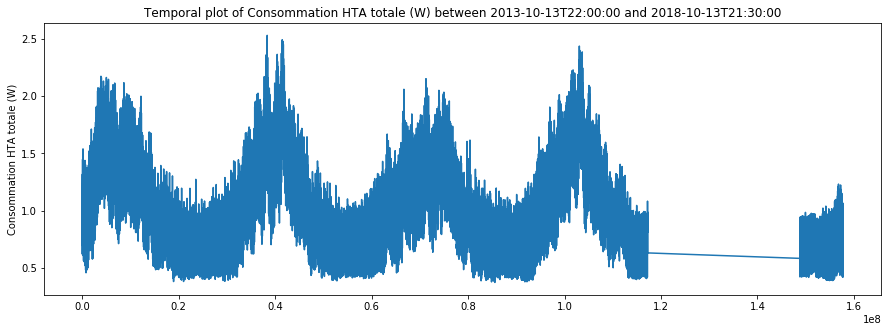

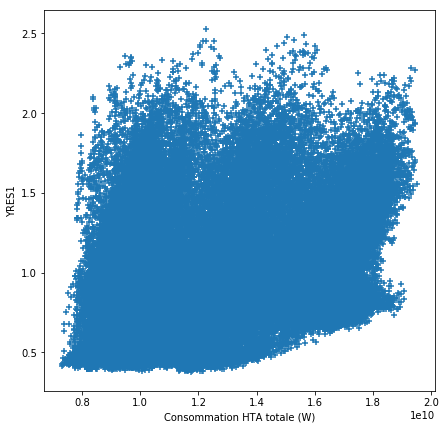

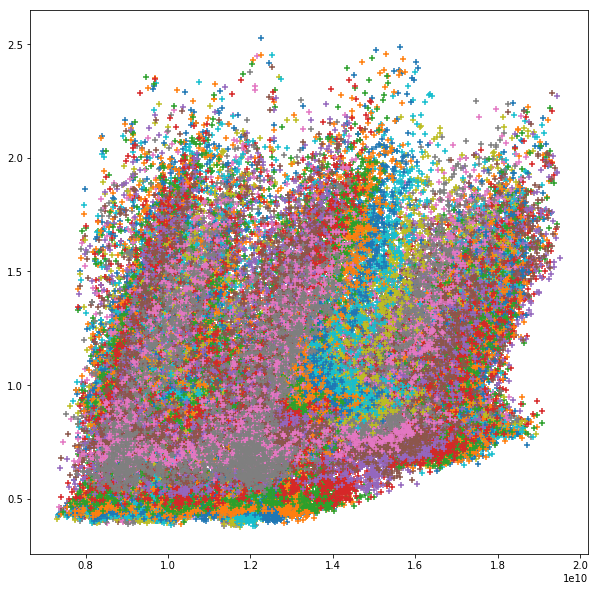

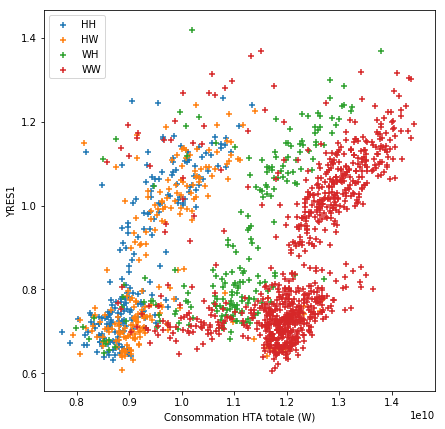

In [4]:
# PLOT DATA
min_id = 0
max_id = n_res
x_id = 23
y_id = 1

plt.figure(figsize=(15, 5))
vis.plot_time(x_res[min_id:max_id, 1], y_res[min_id:max_id, y_id], label_x=x_labels[x_id])
plt.show()

plt.figure(figsize=(7, 7))
vis.plot_series(x_res[min_id:max_id, x_id], y_res[min_id:max_id, y_id], 
                label_a=x_labels[x_id], label_b='YRES{}'.format(y_id))
plt.show()

plt.figure(figsize=(10, 10))
for k in range(48):
    vis.plot_series(x_res[min_id+k:max_id:48, x_id], y_res[min_id+k:max_id:48, y_id])
plt.show()

plt.figure(figsize=(7, 7))
vis.plot_dayclass(x_res, y_res, x_labels, x_id, y_id, min_id, max_id)
plt.savefig('HTA_dayclass_{}_{}.png'.format(x_id, y_id))
plt.show()

Proportion of the validation set: 12.3%


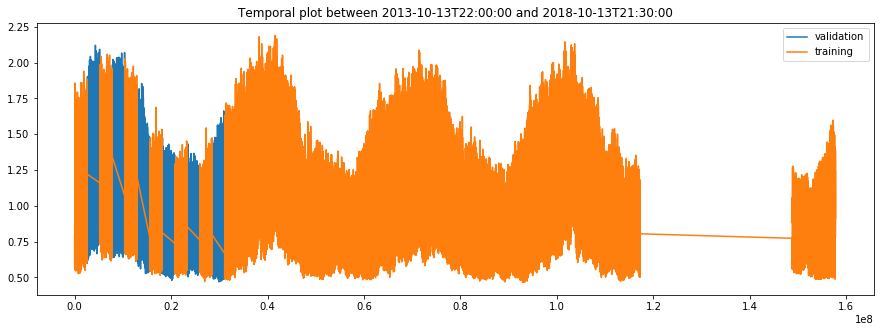

In [5]:
# SEPARATE TRAINING/VALIDATION SETS
is_valid = data.separate_x_res(n_res)
print('Proportion of the validation set: {:.1f}%'.format(100 * np.sum(is_valid)/n_res))

# plot validation set
plt.figure(figsize=(15, 5))
ind = np.where(is_valid)[0]
vis.plot_time(x_res[ind, 1], y_res[ind, 0], label_curve='validation')
ind = np.where([not is_valid[i] for i in range(x_res.shape[0])])[0]
vis.plot_time(x_res[ind, 1], y_res[ind, 0], label_curve='training')
plt.legend(loc='best')
plt.show()

In [81]:
def create_features(x_train, min_timestamp=1381694400):
    holidays = data.holiday_list()
    day_labels = ['HH', 'HW', 'WH', 'WW']
    n, m = x_train.shape
    features = np.zeros((n, 30), dtype=np.float)
    for i in range(n):
        vec = np.zeros(30, dtype=np.float)
        t = x_train[i, 1]
        dt = datetime.datetime.fromtimestamp(t + min_timestamp)
        weekday = dt.weekday()
        dayclass = data.dayclass(t, holidays)
        vec[day_labels.index(dayclass)] = 1  # dayclass (one hot)
        vec[4+weekday] = 1  # day of the week (one hot)
        beg_year = time.mktime(datetime.datetime.strptime('{}'.format(dt.year), '%Y').timetuple())
        timestamp = t + min_timestamp - beg_year
        vec[11] = timestamp  # time from the beginning of the year
        vec[12:25] = x_train[i][3:16]
        vec[25:28] = x_train[i][18:21]
        vec[28:30] = x_train[i][23:25]
        features[i] = vec
    return features

feats_res = create_features(x_res)

halfhour_res = np.zeros(n_res, dtype=np.int)
for i in range(n_res):
    t = x_res[i, 1]
    date = datetime.datetime.fromtimestamp(t+min_timestamp)
    h, m = date.hour, date.minute
    n = h * 2 + (m // 30)
    halfhour_res[i] = n

id_valid = np.where(is_valid)[0]
x_valid_res = feats[id_valid]
y_valid_res = y_res[id_valid]
hh_valid_res = halfhour_res[id_valid]
id_train = np.where([not is_valid[i] for i in range(x_res.shape[0])])[0]
x_train_res = feats[id_train]
y_train_res = y_res[id_train]
hh_train_res = halfhour_res[id_train]

In [117]:
# NORMALIZE DATA
scaler = StandardScaler()
scaler.fit(x_train_res)
x_train_res = scaler.transform(x_train_res)
x_valid_res = scaler.transform(x_valid_res)

In [118]:
# TRAIN MODEL
models = [None for i in range(48)]
seed = 7
np.random.seed(seed)
batch_size = 32
n_epochs = 100
for i in tqdm.tqdm_notebook(range(48)):
    models[i] = Sequential()
    models[i].add(Dense(32, input_dim=30, kernel_initializer='normal', activation='relu'))
    models[i].add(Dense(16, input_dim=32, kernel_initializer='normal', activation='relu'))
    models[i].add(Dense(4, input_dim=16, kernel_initializer='normal'))
    models[i].compile(loss='mean_squared_error', optimizer='adam')
    ind = np.where(hh_train_res == i)[0]
    x_train, y_train = x_train_res[ind], y_train_res[ind]
    ind = np.arange(x_train.shape[0])
    np.random.shuffle(ind)
    x_train = x_train[ind]
    y_train = y_train[ind]
    # print('Training model {:2d}/{} with {} samples'.format(i+1, 48, len(ind)))
    models[i].fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose=0)

Training model  1/48 with 1281 samples
Training model  2/48 with 1281 samples
Training model  3/48 with 1281 samples
Training model  4/48 with 1281 samples
Training model  5/48 with 1278 samples
Training model  6/48 with 1278 samples
Training model  7/48 with 1284 samples
Training model  8/48 with 1284 samples
Training model  9/48 with 1281 samples
Training model 10/48 with 1281 samples
Training model 11/48 with 1281 samples
Training model 12/48 with 1281 samples
Training model 13/48 with 1281 samples
Training model 14/48 with 1281 samples
Training model 15/48 with 1281 samples
Training model 16/48 with 1281 samples
Training model 17/48 with 1281 samples
Training model 18/48 with 1281 samples
Training model 19/48 with 1281 samples
Training model 20/48 with 1281 samples
Training model 21/48 with 1281 samples
Training model 22/48 with 1281 samples
Training model 23/48 with 1281 samples
Training model 24/48 with 1281 samples
Training model 25/48 with 1281 samples
Training model 26/48 with

In [ ]:
# SAVE MODEL
# TODO

In [93]:
# PREDICT VALIDATION Y
def predict_multi(models, X_test, hh_test):
    _, n_out = models[0].get_layer(index=-1).output.shape
    Y_test = np.zeros((X_test.shape[0], n_out))
    inds = []
    for i in tqdm.tqdm_notebook(range(48)):
        ind = np.where(hh_test == i)[0]
        # print('Testing model {:2d}/{} on {} samples'.format(i+1, 48, ind.shape[0]))
        X_test_hh = X_test[ind]
        Y_test_hh = models[i].predict(X_test_hh)
        Y_test[ind] = Y_test_hh
    return Y_test

y_valid_pred_res = predict_multi(models, x_valid_res, hh_valid_res)

[[0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 1.85984233e+09
  1.00341985e+10 4.74947660e+08]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 1.79511081e+09
  1.00215543e+10 4.81727020e+08]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 1.74057699e+09
  1.06449525e+10 4.77806330e+08]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.10953536e+09
  1.23788644e+10 3.59191666e+08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.00970801e+09
  1.22530453e+10 3.62832000e+08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.93311209e+09
  1.22107897e+10 3.64777667e+08]]


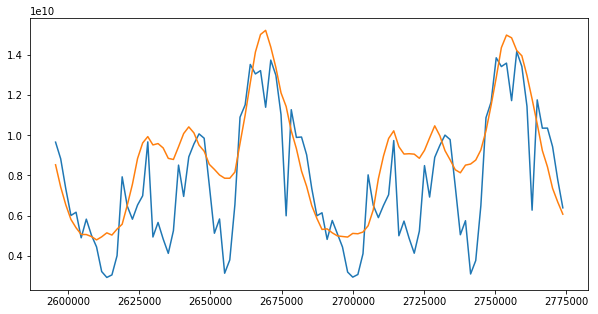

In [116]:
print(x_valid_res)
t_valid = x_res[id_valid, 1]
t_valid = t_valid[:100]
y_valid_pred = y_valid_pred_res[:100, 0]
y_valid_gt = y_valid_res[:100, 0]
plt.figure(figsize=(10,5))
plt.plot(t_valid, y_valid_pred)
plt.plot(t_valid, y_valid_gt*8000000000)
plt.show()